In [1]:
#Data Management
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import math

#Data visualization
import pylab as pl
%pylab inline

#Feature selection
from scipy import stats
from sklearn import cross_validation
import statsmodels.formula.api as smf

import operator

#Neural networks
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.optimizers import RMSprop
from keras.regularizers import l1

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.cross_validation import train_test_split

from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

Populating the interactive namespace from numpy and matplotlib


/Users/bh1555/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.
/Users/bh1555/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Data preparation
* Standardize
* Removing outliers

In [18]:
data = pd.read_csv('../data/output/00DATASET_READY.csv', index_col=0, parse_dates = ['Date'])

In [19]:
data = data.fillna(0)
data = data.replace(np.inf, 0)
data = data.replace(-np.inf, 0)
data['CBG'] = data['CBG'].astype(str)
data['year'] = data['Date'].dt.year

data = data[data['pop']>0]
data = data[data['hh']>0]
data = data[data['com_count']>0]
#data = data.drop(['hh'], axis = 1)

In [20]:
data.head(2)

,CBG,com_count,Date,vio_count,year,pop,female_r,elderly_r,white_r,black_r,...,longercommute_r,avg_bldng_age,gas_utility_r,ownership_r,Temp_min (F),Prep_sum (in),Snow (in),WindSpeed (mph),Weather_events,Holiday_Count
4,360050004001,1.0,2014-03-17,0.0,2014,825.0,0.392727,0.038788,0.132121,0.3600,...,0.387302,48.741325,0.816733,0.525896,25.0,0.72,0.0,14.0,0.0,0.0
10,360050016003,1.0,2014-03-17,0.0,2014,731.0,0.584131,0.157319,0.203830,0.4487,...,0.520000,44.057357,0.212042,0.000000,25.0,0.72,0.0,14.0,0.0,0.0


In [21]:
data.columns

Index([u'CBG', u'com_count', u'Date', u'vio_count', u'year', u'pop',
       u'female_r', u'elderly_r', u'white_r', u'black_r', u'asian_r', u'hh',
       u'hh_child_6_r', u'hh_living_alone_r', u'edu_high_r', u'non_eng_r',
       u'unemployed_r', u'vacancy_r', u'med_rent', u'med_income', u'merried_r',
       u'longercommute_r', u'avg_bldng_age', u'gas_utility_r', u'ownership_r',
       u'Temp_min (F)', u'Prep_sum (in)', u'Snow (in)', u'WindSpeed (mph)',
       u'Weather_events', u'Holiday_Count'],
      dtype='object')

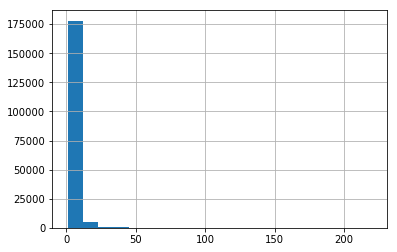

In [22]:
data['com_count'].hist(bins = 20)

# Trick: data['com/hh'] = (data['com_count']+1) / data['hh']

In [23]:
data['com/hh'] = data['com_count'] / data['hh']

In [24]:
data.describe()

,com_count,vio_count,year,pop,female_r,elderly_r,white_r,black_r,asian_r,hh,...,avg_bldng_age,gas_utility_r,ownership_r,Temp_min (F),Prep_sum (in),Snow (in),WindSpeed (mph),Weather_events,Holiday_Count,com/hh
count,184567.000000,184567.000000,184567.000000,184567.000000,184567.000000,184567.000000,184567.000000,184567.000000,184567.000000,184567.000000,...,184567.000000,184567.000000,184567.000000,184567.000000,184567.000000,184567.000000,184567.000000,184567.000000,184567.000000,184567.000000
mean,3.101248,0.644736,2015.124383,1463.589938,0.523869,0.077189,0.355596,0.306697,0.099382,269.859726,...,60.772847,0.560932,0.224243,32.488711,0.858199,0.693149,11.958546,0.804548,0.227142,0.020242
std,4.714861,1.742252,0.779609,628.635113,0.066774,0.060641,0.290473,0.307624,0.153830,176.992482,...,10.125674,0.244020,0.211610,15.265999,0.833226,2.440098,2.412586,1.051761,0.418987,0.070144
min,1.000000,0.000000,2014.000000,18.000000,0.184211,0.000000,0.000000,0.000000,0.000000,2.000000,...,10.189922,0.000000,0.000000,1.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000347
25%,1.000000,0.000000,2015.000000,1027.000000,0.481909,0.037016,0.106487,0.033602,0.000000,145.000000,...,55.255450,0.345729,0.050139,23.000000,0.180000,0.000000,10.000000,0.000000,0.000000,0.004310
50%,2.000000,0.000000,2015.000000,1371.000000,0.523752,0.063357,0.261337,0.196937,0.036344,241.000000,...,62.914980,0.583039,0.166096,33.000000,0.630000,0.000000,12.000000,0.000000,0.000000,0.008322
75%,3.000000,0.000000,2016.000000,1779.000000,0.567420,0.102243,0.598651,0.541315,0.125935,358.000000,...,68.545788,0.779927,0.340342,40.000000,1.360000,0.000000,14.000000,1.000000,0.000000,0.018182
max,220.000000,78.000000,2016.000000,10211.000000,1.000000,0.688555,1.000000,1.000000,1.000000,2878.000000,...,76.000000,1.000000,1.000000,73.000000,4.980000,16.900000,18.000000,5.000000,1.000000,8.230769


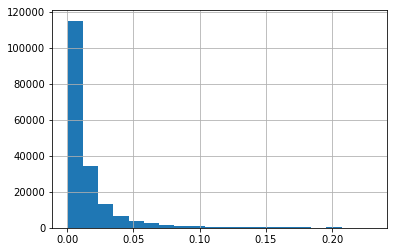

In [25]:
data = data[data['com/hh'] < (data['com/hh'].mean() + 3*data['com/hh'].std())]
data['com/hh'].hist(bins = 20)

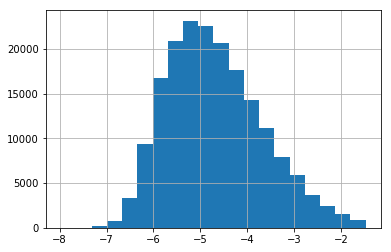

In [26]:
data['log_com/hh'] = np.log(data['com/hh'])
data['log_com/hh'].hist(bins=20)

In [27]:
print len(data.columns)
print data.columns

33
Index([u'CBG', u'com_count', u'Date', u'vio_count', u'year', u'pop',
       u'female_r', u'elderly_r', u'white_r', u'black_r', u'asian_r', u'hh',
       u'hh_child_6_r', u'hh_living_alone_r', u'edu_high_r', u'non_eng_r',
       u'unemployed_r', u'vacancy_r', u'med_rent', u'med_income', u'merried_r',
       u'longercommute_r', u'avg_bldng_age', u'gas_utility_r', u'ownership_r',
       u'Temp_min (F)', u'Prep_sum (in)', u'Snow (in)', u'WindSpeed (mph)',
       u'Weather_events', u'Holiday_Count', u'com/hh', u'log_com/hh'],
      dtype='object')


In [28]:
print data.columns[32]

log_com/hh


In [29]:
cbg = [data.columns[0]]
com = [data.columns[32]]
Date = [data.columns[2]]
vio = [data.columns[3]]

demo = list(data.columns[5:22])
phys = list(data.columns[22:25])
weather = list(data.columns[25:30])
holiday = [data.columns[30]]

year = [data.columns[4]]

In [30]:
df = data[cbg + com + demo + phys + weather + Date]

In [31]:

print len(df)
df.head(2)

183226


,CBG,log_com/hh,pop,female_r,elderly_r,white_r,black_r,asian_r,hh,hh_child_6_r,...,longercommute_r,avg_bldng_age,gas_utility_r,ownership_r,Temp_min (F),Prep_sum (in),Snow (in),WindSpeed (mph),Weather_events,Date
4,360050004001,-5.402677,825.0,0.392727,0.038788,0.132121,0.3600,0.0,222.0,0.076577,...,0.387302,48.741325,0.816733,0.525896,25.0,0.72,0.0,14.0,0.0,2014-03-17
10,360050016003,-4.844187,731.0,0.584131,0.157319,0.203830,0.4487,0.0,127.0,0.000000,...,0.520000,44.057357,0.212042,0.000000,25.0,0.72,0.0,14.0,0.0,2014-03-17


In [32]:
df.describe()

,log_com/hh,pop,female_r,elderly_r,white_r,black_r,asian_r,hh,hh_child_6_r,hh_living_alone_r,...,merried_r,longercommute_r,avg_bldng_age,gas_utility_r,ownership_r,Temp_min (F),Prep_sum (in),Snow (in),WindSpeed (mph),Weather_events
count,183226.000000,183226.000000,183226.000000,183226.000000,183226.000000,183226.000000,183226.000000,183226.000000,183226.000000,183226.000000,...,183226.000000,183226.000000,183226.000000,183226.000000,183226.000000,183226.000000,183226.000000,183226.000000,183226.000000,183226.000000
mean,-4.684731,1467.457353,0.523980,0.076887,0.355178,0.306815,0.099499,271.500999,0.221071,0.308775,...,0.394151,0.504699,60.774470,0.561267,0.224872,32.528702,0.858202,0.690061,11.956917,0.803188
std,1.019301,627.711041,0.066520,0.060302,0.290498,0.307472,0.154008,176.498214,0.206082,0.144470,...,0.123938,0.166639,10.112786,0.243991,0.211805,15.265295,0.833253,2.433234,2.413043,1.051413
min,-7.964851,18.000000,0.184211,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,...,0.000000,0.000000,10.189922,0.000000,0.000000,1.000000,0.000000,0.000000,6.000000,0.000000
25%,-5.451038,1031.000000,0.482021,0.036996,0.106420,0.033602,0.000000,147.000000,0.061688,0.203390,...,0.306189,0.409605,55.258134,0.345873,0.050420,23.000000,0.180000,0.000000,10.000000,0.000000
50%,-4.799914,1375.000000,0.523923,0.063181,0.260786,0.197468,0.036405,243.000000,0.176744,0.294118,...,0.388661,0.524838,62.910490,0.583979,0.167082,33.000000,0.610000,0.000000,12.000000,0.000000
75%,-4.025352,1782.000000,0.567420,0.101673,0.598577,0.541315,0.125961,359.000000,0.327485,0.395735,...,0.478166,0.620773,68.530604,0.780220,0.340909,40.000000,1.360000,0.000000,14.000000,1.000000
max,-1.469676,10211.000000,1.000000,0.688555,1.000000,1.000000,1.000000,2878.000000,1.000000,0.891135,...,1.000000,1.000000,76.000000,1.000000,1.000000,73.000000,4.980000,16.900000,18.000000,5.000000


In [33]:
print len(df['CBG'].unique())
print df.columns

5790
Index([u'CBG', u'log_com/hh', u'pop', u'female_r', u'elderly_r', u'white_r',
       u'black_r', u'asian_r', u'hh', u'hh_child_6_r', u'hh_living_alone_r',
       u'edu_high_r', u'non_eng_r', u'unemployed_r', u'vacancy_r', u'med_rent',
       u'med_income', u'merried_r', u'longercommute_r', u'avg_bldng_age',
       u'gas_utility_r', u'ownership_r', u'Temp_min (F)', u'Prep_sum (in)',
       u'Snow (in)', u'WindSpeed (mph)', u'Weather_events', u'Date'],
      dtype='object')


# Standardize data
* Standardizing independent variables
* rescaling dependent variable

In [372]:
#Function to rescale a feature
#def inv(y_init, y_bound):
#    y_std = ((y_init - y_bound.min()))/(y_bound.max() - y_bound.min())
#    return y_std

#Function to recover the original feature from the rescaled version
#def rev_inv(y_init, y_bound):
#    y_std = y_init*(y_bound.max() - y_bound.min()) + y_bound.min()
#    return y_std

In [94]:
#var_int = ['hh', 'hh_living_alone_r','ownership_r','med_rent','elderly_r','hh_child_6_r','edu_high_r','white_r','female_r',
# 'med_income', 'black_r','vacancy_r','non_eng_r','avg_bldng_age','gas_utility_r','ownership_r','Temp_min (F)',
#           'Prep_sum (in)','Snow (in)','WindSpeed (mph)','Weather_events']

In [132]:
#Define a function to prepare a dataframe for prediction
def prepare_df(df):
    
    #Keep only the year of interest & permutate rows
    #df = df[df.Date_str < Date]
    df = df.iloc[np.random.permutation(len(df))].reset_index(drop=True)

    #As I have percentages and medians, I standardise the variables (substract the mean and divise by the std)
    var_std = StandardScaler().fit(df[var_int]).transform(df[var_int])
    df_std = pd.DataFrame(var_std, columns=var_int).astype(np.float32)
        
    #Ref_pc is the tons of refuse per person, and (sometimes) outcome to be predicted
    df_std['log_com/hh'] = df['log_com/hh']
    
    df_std['CBG'] = df['CBG']
    df_std['Date'] = df['Date']
    df_std['hh_real'] = df['hh']
    return df_std

var_int = demo + phys + weather
var_int.remove('pop')
var_int.remove('merried_r')
df_std = prepare_df(df)

In [133]:
print len(df_std)
df_std.head(2)

183226


,female_r,elderly_r,white_r,black_r,asian_r,hh,hh_child_6_r,hh_living_alone_r,edu_high_r,non_eng_r,...,ownership_r,Temp_min (F),Prep_sum (in),Snow (in),WindSpeed (mph),Weather_events,log_com/hh,CBG,Date,hh_real
0,0.586979,-0.125356,-0.535627,1.557545,-0.646067,-1.141663,2.393298,-0.132342,-0.206602,-1.143088,...,3.659634,-0.951750,2.522406,0.373964,2.089933,1.138291,-4.248495,360471058041,2016-01-18,70.0
1,0.894878,-0.470579,-1.222654,1.970487,-0.646067,1.464602,-1.072736,-1.006498,-1.067406,-1.143088,...,-0.956518,-0.165651,-0.237866,-0.283599,0.017854,2.089395,-6.272877,360471130003,2016-12-05,530.0


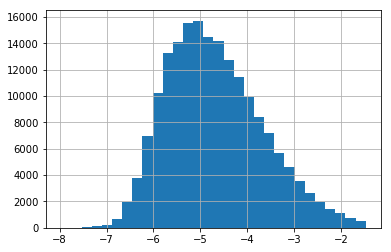

In [134]:
df_std['log_com/hh'].hist(bins = 30)

In [135]:
print len(df_std)

183226


In [136]:
print len(df_std.columns)
print df_std.columns

27
Index([u'female_r', u'elderly_r', u'white_r', u'black_r', u'asian_r', u'hh',
       u'hh_child_6_r', u'hh_living_alone_r', u'edu_high_r', u'non_eng_r',
       u'unemployed_r', u'vacancy_r', u'med_rent', u'med_income',
       u'longercommute_r', u'avg_bldng_age', u'gas_utility_r', u'ownership_r',
       u'Temp_min (F)', u'Prep_sum (in)', u'Snow (in)', u'WindSpeed (mph)',
       u'Weather_events', u'log_com/hh', u'CBG', u'Date', u'hh_real'],
      dtype='object')


In [137]:
df_std.columns[25]

'Date'

# Split dataset
* 2014-2015: train and validate data
* 2016: test data

In [138]:
df_std_train = df_std[df_std['Date'] < '2016-09-01']
df_std_test = df_std[df_std['Date'] >= '2016-09-01']

# Train and validate set
X = df_std_train.iloc[:, :23]
Y = df_std_train.iloc[:, 23]

# Test set
X_2016 = df_std_test.iloc[:, :23]
X_2016 = np.asarray(X_2016)

Y_2016 = df_std_test.iloc[:, 23]
Y_2016 = np.asarray(Y_2016)

CBG_2016 = df_std_test.iloc[:,24]
CBG_2016 = np.asarray(CBG_2016)

hh_2016 = df_std_test.iloc[:, 26]
hh_2016 = np.asarray(hh_2016)

In [139]:
CBG_2016[:2]

array(['360471130003', '360470916001'], dtype=object)

In [140]:
print len(X)
print len(X_2016)

155217
28009


In [112]:
#df['year'].unique()

# Predictive Modeling
* First, by use of train data (2014-2015 cbg level), building a predictive model
* Evaluate model performance (RMSE and R-squared value)
* Predicting 2016 cbg level complaints

# NN

In [ ]:
for i in range(2):
    #r_sq = []
    #rmse = []
    
    #actual = []
    #predict = []
    
    train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.3, random_state=6)
    
    train_X = np.asarray(train_X)
    test_X = np.asarray(test_X)
    train_Y = np.asarray(train_Y)
    test_Y = np.asarray(test_Y)
    
    model = Sequential()
    model.add(Dense(output_dim=128, input_dim=np.shape(train_X)[1]))
    #Add a simple hidden layer
    model.add(Dropout(0.2))
    model.add(Activation('tanh'))
    #Add an output layer
    model.add(Dense(output_dim=1))
    model.add(Activation('linear'))
    #Compile the mean squared error of the optimization
    model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy'])
        
    history = model.fit(train_X, train_Y, nb_epoch=100, batch_size=32, verbose=0)

    predict_Y = model.predict(test_X, batch_size = 16).reshape(test_X.shape[0],)
    
    print r2_score(test_Y, predict_Y), np.sqrt(mean_squared_error(test_Y, predict_Y))
    print '---------------------------------------'
    
    #test_Y.append(actual)
    #predict_Y.append(predict)
    
    #r2_score(test_Y, predict_Y).append(r_sq)
    #np.sqrt(mean_squared_error(test_Y, predict_Y)).append(rmse)

# GBRT
* Ignore date, temporal, or historical data
* Weahter underground data can be presented seasonal pattern
* Mix randomly
* 70%: Train data, 30%: Test data

In [141]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=6)

In [142]:
estimator = GradientBoostingRegressor(random_state=6)
param_grid = {'loss': ['lad'], 
              'max_depth': [6], 'n_estimators': [200], 'learning_rate': [0.1], 
              'subsample': [0.8], 'max_features': ['sqrt']}

In [143]:
def GB_bestEstimator(estimator, param_grid, X_train, Y_train):
    param_grid = param_grid
    gs = GridSearchCV(estimator=estimator, param_grid=param_grid, 
                      scoring='r2', cv=3, n_jobs=-1)
    gs = gs.fit(X_train, Y_train)
    return gs.best_estimator_, gs.grid_scores_

In [144]:
best_estimator, grid_scores = GB_bestEstimator(estimator, param_grid, X_train, Y_train)

In [145]:
Y_predict = best_estimator.predict(X_test)
#Y_predict_o = rev_inv(Y_predict, df['com_count'])

In [146]:
r2_score(Y_test, Y_predict)

0.52739839223389406

In [147]:
np.sqrt(mean_squared_error(Y_test, Y_predict))

0.70309381005130567

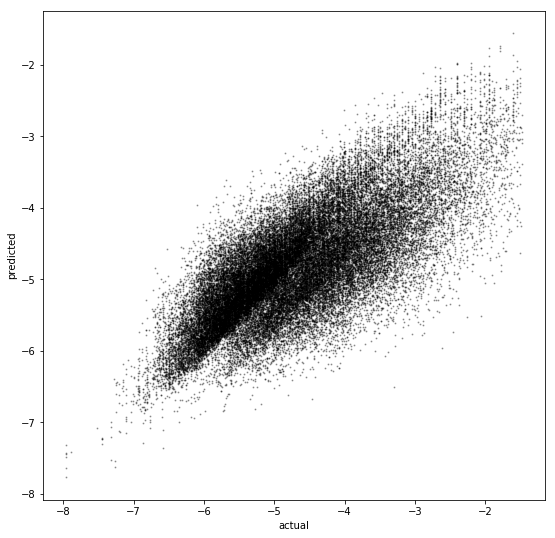

In [148]:
fig = plt.figure(figsize=(9,9))
#x = range(300)
#y = x
plt.scatter(Y_test, Y_predict, color = 'k', s = 1, alpha=0.3)
#plt.plot(x, y, '--r')
plt.xlabel('actual')
plt.ylabel('predicted')
#plt.xlim(0,20)
#plt.ylim(0,20)
plt.show()

In [149]:
# Feature importance
importance = best_estimator.feature_importances_

features = df_std.columns[:23] ##### weather data used 30 not 24

feature_importance = pd.DataFrame()
feature_importance['feature'] = features
feature_importance['value'] = importance
feature_importance.sort(['value'], ascending = False)

/Users/bh1555/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,feature,value
5,hh,0.179853
18,Temp_min (F),0.094805
16,gas_utility_r,0.052054
7,hh_living_alone_r,0.051526
17,ownership_r,0.051180
12,med_rent,0.045609
15,avg_bldng_age,0.044799
19,Prep_sum (in),0.039488
1,elderly_r,0.037424
8,edu_high_r,0.036112


In [150]:
Y_predict_2016 = best_estimator.predict(X_2016)

In [151]:
r2_score(Y_2016, Y_predict_2016)

0.44025354812074768

In [152]:
result_2016 = pd.DataFrame()
result_2016['CBG'] = CBG_2016
result_2016['Actual_logcomhh'] = Y_2016
result_2016['Predicted_logcomhh'] = Y_predict_2016
result_2016['hh_2016'] = hh_2016
result_2016['Actual_comhh'] = np.exp(result_2016['Actual_logcomhh'])
result_2016['Predicted_comhh'] = np.exp(result_2016['Predicted_logcomhh'])
result_2016['Actual'] = (result_2016['Actual_comhh'] * result_2016['hh_2016'])-1
result_2016['Predicted'] = (result_2016['Predicted_comhh'] * result_2016['hh_2016']) -1

In [153]:
result_2016.head()

,CBG,Actual_logcomhh,Predicted_logcomhh,hh_2016,Actual_comhh,Predicted_comhh,Actual,Predicted
0,360471130003,-6.272877,-5.475120,530.0,0.001887,0.004190,2.220446e-16,1.220554
1,360470916001,-5.303305,-4.450968,201.0,0.004975,0.011667,0.000000e+00,1.345121
2,360050220001,-3.801712,-4.849029,403.0,0.022333,0.007836,8.000000e+00,2.157900
3,360470143003,-3.931826,-3.677113,51.0,0.019608,0.025296,0.000000e+00,0.290091
4,360470762002,-6.368187,-6.082129,583.0,0.001715,0.002283,2.220446e-16,0.331169


In [154]:
print len(result_2016)
print len(result_2016['CBG'].unique())

28009
4900


In [155]:
result_2016['error'] = result_2016['Actual'] - result_2016['Predicted']

In [156]:
result_2016.describe()

,Actual_logcomhh,Predicted_logcomhh,hh_2016,Actual_comhh,Predicted_comhh,Actual,Predicted,error
count,28009.000000,28009.000000,28009.000000,28009.000000,28009.000000,2.800900e+04,28009.000000,28009.000000
mean,-4.648608,-4.904246,272.253276,0.017024,0.010212,2.069656e+00,0.761053,1.308603
std,1.015927,0.741402,177.335094,0.024641,0.011509,3.731534e+00,0.854420,3.455015
min,-7.964851,-7.736761,5.000000,0.000347,0.000436,-5.551115e-16,-0.343186,-6.630240
25%,-5.402677,-5.418840,148.000000,0.004505,0.004432,0.000000e+00,0.197793,-0.326133
50%,-4.753590,-4.971380,244.000000,0.008621,0.006934,1.000000e+00,0.516462,0.137976
75%,-3.988984,-4.471096,361.000000,0.018519,0.011435,2.000000e+00,1.035349,1.746278
max,-1.481605,-1.546482,2878.000000,0.227273,0.212996,7.400000e+01,13.526108,64.066131


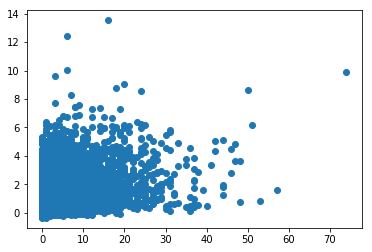

In [157]:
plt.scatter(result_2016['Actual'], result_2016['Predicted'])

In [158]:
result_2016['Actual_int'] = result_2016['Actual'].astype(int)
result_2016['Predicted_int'] = (result_2016['Predicted']+1).astype(int)
result_2016.sort(['Actual'], ascending = False)

/Users/bh1555/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


,CBG,Actual_logcomhh,Predicted_logcomhh,hh_2016,Actual_comhh,Predicted_comhh,Actual,Predicted,error,Actual_int,Predicted_int
9565,360050050012,-1.767011,-3.692634,439.0,0.170843,0.024906,7.400000e+01,9.933869,64.066131,74,10
5384,360610259001,-2.304308,-5.397346,581.0,0.099828,0.004529,5.700000e+01,1.631106,55.368894,57,2
17501,360610175007,-1.536469,-4.909904,251.0,0.215139,0.007373,5.300000e+01,0.850672,52.149328,53,1
21413,360470357001,-2.602690,-4.583971,702.0,0.074074,0.010214,5.100000e+01,6.170405,44.829595,51,7
21684,360050050012,-2.152674,-3.816104,439.0,0.116173,0.022013,5.000000e+01,8.663883,41.336117,49,9
17387,360470802003,-1.841521,-4.195226,309.0,0.158576,0.015067,4.800000e+01,3.655808,44.344192,48,4
25279,360810857002,-2.018976,-5.359573,369.0,0.132791,0.004703,4.800000e+01,0.735374,47.264626,48,1
25945,360050050012,-2.213298,-4.325507,439.0,0.109339,0.013227,4.700000e+01,4.806585,42.193415,47,5
1721,360050050012,-2.213298,-4.547143,439.0,0.109339,0.010597,4.700000e+01,3.652274,43.347726,47,4
26776,360610233001,-2.642092,-5.150715,660.0,0.071212,0.005795,4.600000e+01,2.824870,43.175130,46,3


In [357]:
result_2016.to_csv('../data/dataprocessing/00result_sample_11072016.csv')